In [63]:
!pip install --upgrade pandas_datareader

In [64]:
import pandas as pd
from pandas_datareader import data as data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import pickle

from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, LSTM, GRU, InputLayer, Dropout, Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [65]:
import warnings
warnings.filterwarnings("ignore")

In [66]:
nifty50 = data.DataReader('^NSEI',data_source='yahoo', start='2010-01-01', end='2022-04-22')
nifty50.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,5238.450195,5167.100098,5200.899902,5232.200195,0.0,5232.200195
2010-01-05,5288.350098,5242.399902,5277.149902,5277.899902,0.0,5277.899902
2010-01-06,5310.850098,5260.049805,5278.149902,5281.799805,0.0,5281.799805
2010-01-07,5302.549805,5244.750000,5281.799805,5263.100098,0.0,5263.100098
2010-01-08,5276.750000,5234.700195,5264.250000,5244.750000,0.0,5244.750000


In [67]:
nifty50 = nifty50[['Adj Close']]
nifty50.tail()

,Adj Close
Date,
2022-04-18,17173.650391
2022-04-19,16958.650391
2022-04-20,17136.550781
2022-04-21,17392.599609
2022-04-22,17171.949219


In [68]:
nifty50.isnull().sum()

Adj Close    0
dtype: int64

Text(0.5, 1.0, 'Nifty 50 Chart')

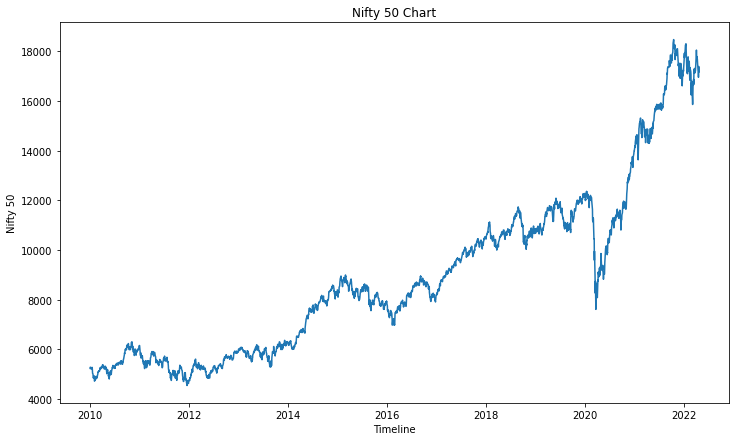

In [69]:
plt.rcParams["figure.figsize"] = (12,7)
plt.plot(nifty50['Adj Close'])
plt.xlabel("Timeline")
plt.ylabel("Nifty 50")
plt.title("Nifty 50 Chart")

Seasonal Decomposition

In [70]:
nifty50.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2022-04-07', '2022-04-08', '2022-04-11', '2022-04-12',
               '2022-04-13', '2022-04-18', '2022-04-19', '2022-04-20',
               '2022-04-21', '2022-04-22'],
              dtype='datetime64[ns]', name='Date', length=3016, freq=None)

In [71]:
nifty50.isnull().sum()

Adj Close    0
dtype: int64

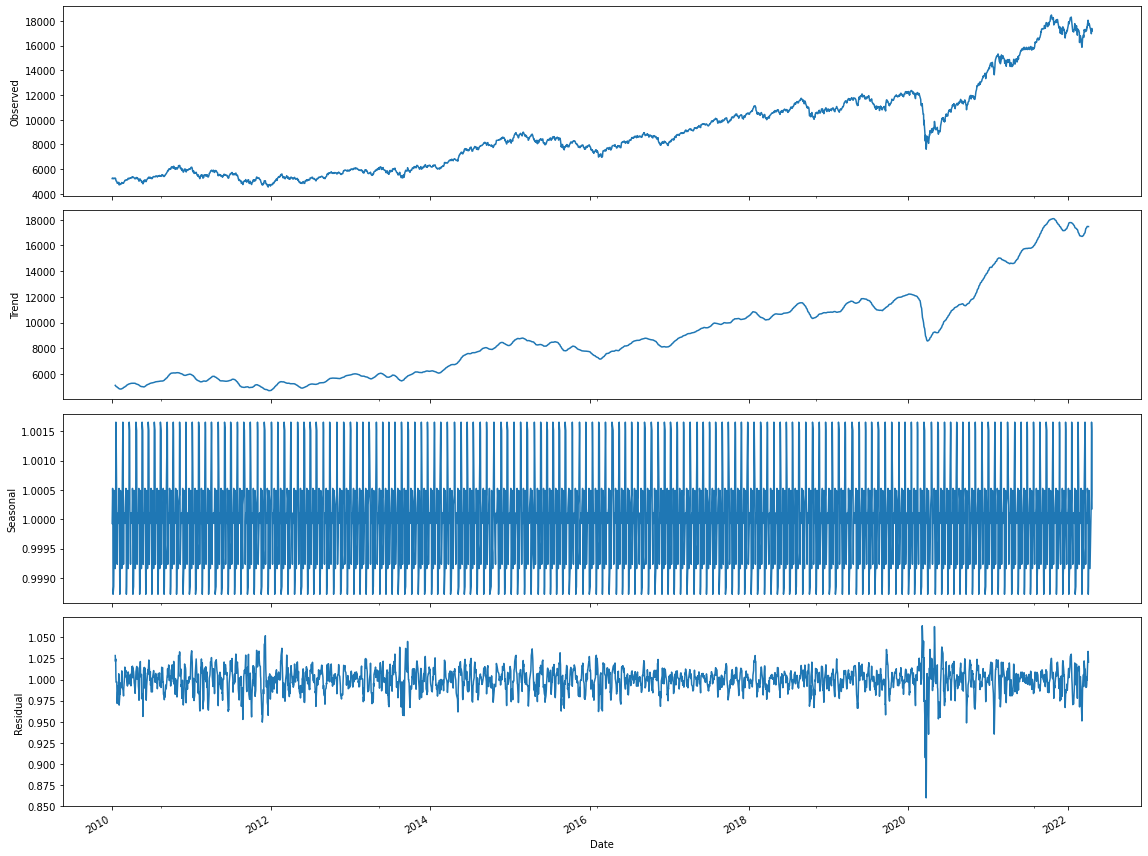

In [72]:
plt.rcParams["figure.figsize"] = (16,12)
decomposition = sm.tsa.seasonal_decompose(nifty50['Adj Close'], model = 'multiplicative', freq=20)
fig = decomposition.plot()
plt.show()

## Check for Stationarity

In [73]:
def adfuller_test(data):
  # H0: data is not stationary (has unit root)
  # H1: data is stationary (doesn't have unit root)
  results = adfuller(data, autolag="AIC")

  test_stat = results[0]
  p_value = results[1]
  print(" Test Statistic: {} \n p-value: {}".format(test_stat, p_value ))
  if p_value <= 0.05:
    print(" Reject H0. Data is stationary")
  else:
    print(" Don't reject H0. Data is not stationary")

Augmented-Dickey Fuller Test Results - with original Nifty50 data
 Test Statistic: 0.4302520111108603 
 p-value: 0.9825916803748165
 Don't reject H0. Data is not stationary


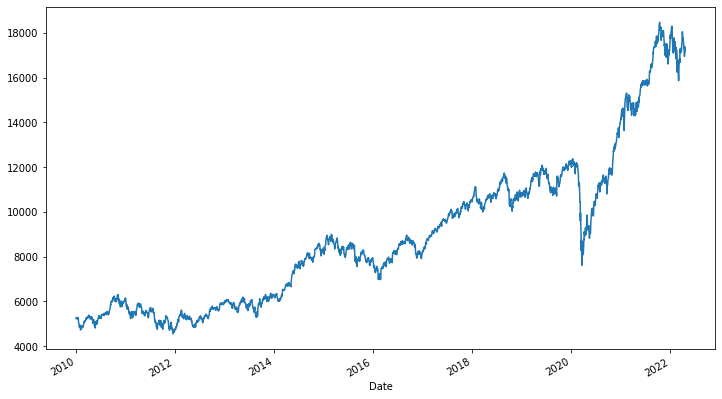

In [74]:
print("Augmented-Dickey Fuller Test Results - with original Nifty50 data")
plt.rcParams["figure.figsize"] = (12,7)
nifty50['Adj Close'].plot()
adfuller_test(nifty50['Adj Close'])

Augmented-Dickey Fuller Test Results - with 1st order difference of Nifty50 data
 Test Statistic: -15.243179958401717 
 p-value: 5.129121764282933e-28
 Reject H0. Data is stationary


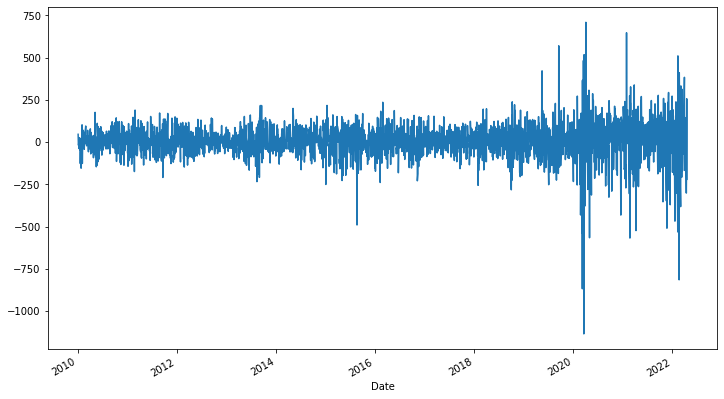

In [75]:
nifty50['AdjClose_Diff1'] = nifty50['Adj Close'] - nifty50['Adj Close'].shift(1)

print("Augmented-Dickey Fuller Test Results - with 1st order difference of Nifty50 data")
nifty50['AdjClose_Diff1'].plot()
adfuller_test(nifty50['AdjClose_Diff1'].dropna())

Augmented-Dickey Fuller Test Results - with 2nd order difference of Nifty50 data
 Test Statistic: -10.01391850076843 
 p-value: 1.7491408878582134e-17
 Reject H0. Data is stationary


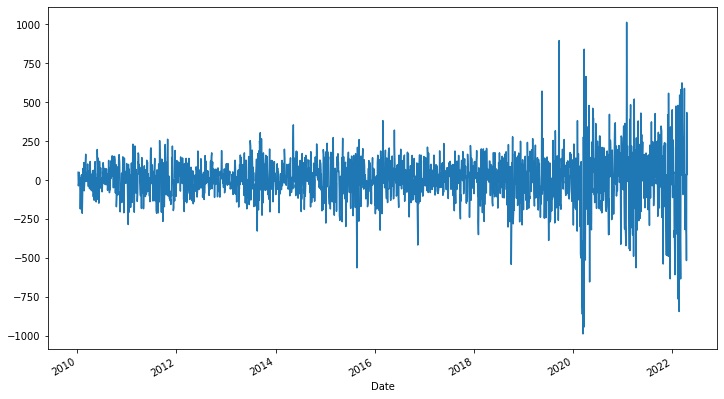

In [76]:
nifty50['AdjClose_Diff2'] = nifty50['Adj Close'] - nifty50['Adj Close'].shift(2)

print("Augmented-Dickey Fuller Test Results - with 2nd order difference of Nifty50 data")
nifty50['AdjClose_Diff2'].plot()
adfuller_test(nifty50['AdjClose_Diff2'].dropna())

In [77]:
nifty50.head()

,Adj Close,AdjClose_Diff1,AdjClose_Diff2
Date,,,
2010-01-04,5232.200195,NaN,NaN
2010-01-05,5277.899902,45.699707,NaN
2010-01-06,5281.799805,3.899902,49.599609
2010-01-07,5263.100098,-18.699707,-14.799805
2010-01-08,5244.750000,-18.350098,-37.049805


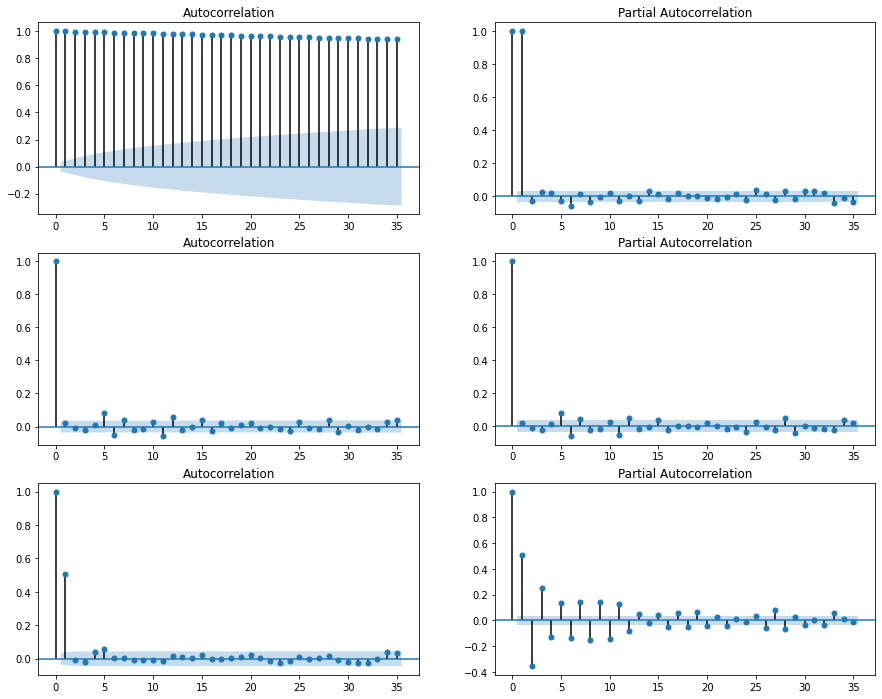

In [78]:
plt.rcParams["figure.figsize"] = (15,12)
fig, ax = plt.subplots(3,2)

plot_acf(nifty50['Adj Close'], ax=ax[0,0]);
plot_pacf(nifty50['Adj Close'], ax=ax[0,1]);
plot_acf(nifty50['AdjClose_Diff1'].dropna(), ax=ax[1,0]);
plot_pacf(nifty50['AdjClose_Diff1'].dropna(), ax=ax[1,1]);
plot_acf(nifty50['AdjClose_Diff2'].dropna(), ax=ax[2,0]);
plot_pacf(nifty50['AdjClose_Diff2'].dropna(), ax=ax[2,1]);

In [79]:
# to maintain the order of the time series data as-is, we are not choosing randomised split for train & test purposes
nifty50_train = nifty50[['Adj Close']][:int(len(nifty50)*0.8)]
nifty50_test = nifty50[['Adj Close']][int(len(nifty50)*0.8):]
nifty50_train.shape, nifty50_test.shape

((2412, 1), (604, 1))

In [80]:
nifty50_train.head()

,Adj Close
Date,
2010-01-04,5232.200195
2010-01-05,5277.899902
2010-01-06,5281.799805
2010-01-07,5263.100098
2010-01-08,5244.750000


In [81]:
nifty50_test.head()

,Adj Close
Date,
2019-11-18,11884.500000
2019-11-19,11940.099609
2019-11-20,11999.099609
2019-11-21,11968.400391
2019-11-22,11914.400391


In [82]:
history = [x for x in nifty50_train['Adj Close']]
predictions510 = []
for t in range(len(nifty50_test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    predictions510.append(model_fit.forecast()[0])
    history.append(nifty50_test['Adj Close'].iloc[t])

In [83]:
error = np.sqrt(mean_squared_error(nifty50_test['Adj Close'], predictions510))
print("Test RMSE: {}".format(error))

Test RMSE: 178.51070082125594


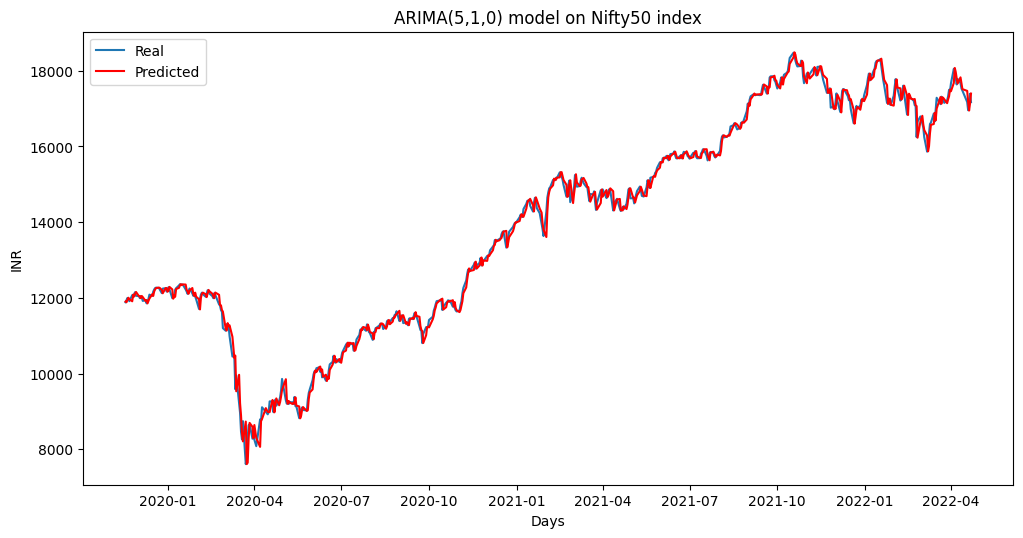

In [84]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(nifty50_test['Adj Close'], label='Real')
plt.plot(pd.DataFrame(predictions510, index=nifty50_test.index), color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('INR')
plt.title('ARIMA(5,1,0) model on Nifty50 index')
plt.legend()
plt.show()

Test RMSE: 178.29270648742477


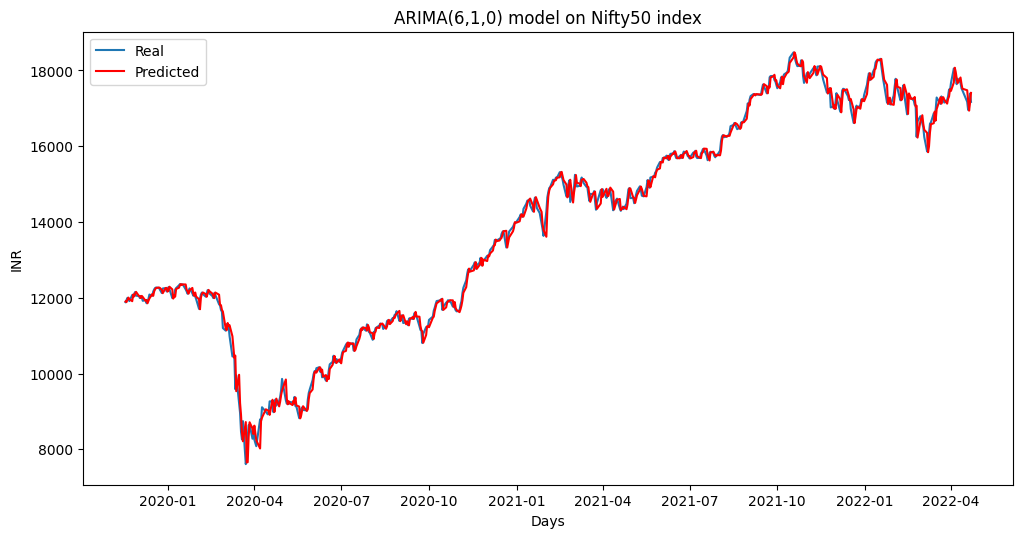

In [85]:
history = [x for x in nifty50_train['Adj Close']]
predictions610 = []
for t in range(len(nifty50_test)):
    model = ARIMA(history, order=(6,1,0))
    model_fit = model.fit()
    predictions610.append(model_fit.forecast()[0])    
    history.append(nifty50_test['Adj Close'].iloc[t])

error = np.sqrt(mean_squared_error(nifty50_test['Adj Close'], predictions610))
print("Test RMSE: {}".format(error))

# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(nifty50_test['Adj Close'], label='Real')
plt.plot(pd.DataFrame(predictions610, index=nifty50_test.index), color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('INR')
plt.title('ARIMA(6,1,0) model on Nifty50 index')
plt.legend()
plt.show()

In [86]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 3014
Model:                 ARIMA(6, 1, 0)   Log Likelihood              -18201.093
Method:                       css-mle   S.D. of innovations            101.484
Date:                Sun, 01 May 2022   AIC                          36418.186
Time:                        06:08:13   BIC                          36466.274
Sample:                             1   HQIC                         36435.479
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0369      1.899      2.125      0.034       0.314       7.760
ar.L1.D.y      0.0244      0.018      1.340      0.180      -0.011       0.060
ar.L2.D.y     -0.0059      0.018     -0.324      0.746      -0.041       0.030
ar.L3.D.y     -0.0231      0.018     -1.274      0.203      -0.059       0.012
ar.L4.D.y      0.0080      0.018      0.438      0.661      -0.028       0.044
ar.L5.D.y      0.0826      0.018      4.544      0.000       0.047       0.118
ar.L6.D.y     -0.0592      0.018     -3.243      0.001      -0.095      -0.023
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2362           -0.7720j            1.4575           -0.4112
AR.2           -1.2362           +0.7720j            1.4575            0.4112
AR.3            0.2273           -1.5031j            1.5202           -0.2261
AR.4            0.2273           +1.5031j            1.5202            0.2261
AR.5            1.7070           -0.7274j            1.8555           -0.0641
AR.6            1.7070           +0.7274j            1.8555            0.0641
-----------------------------------------------------------------------------
"""

In [87]:
pd.DataFrame(predictions610, index=nifty50_test.index, columns=['Prediction'])

,Prediction
Date,
2019-11-18,11903.241902
2019-11-19,11887.879689
2019-11-20,11947.549618
2019-11-21,12005.883758
2019-11-22,11965.974811
...,...
2022-04-18,17478.045490
2022-04-19,17195.704129
2022-04-20,16939.788183


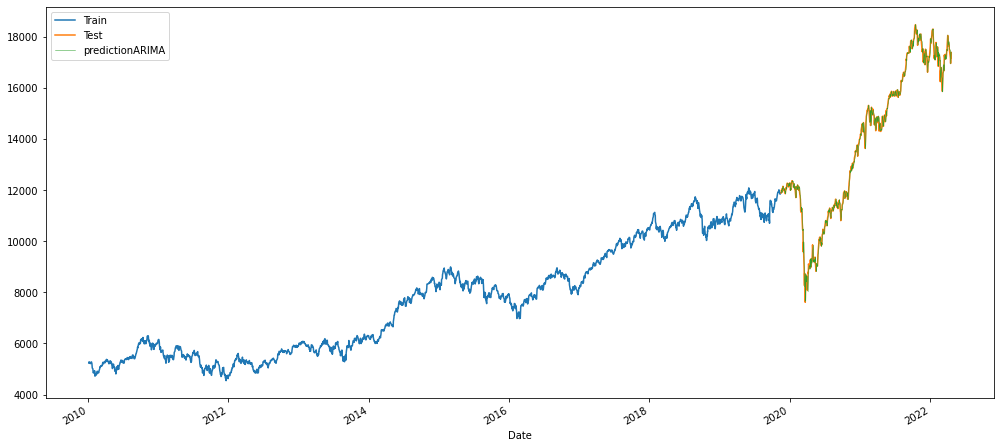

In [88]:
nifty50_train['Adj Close'].plot(legend=True, label = 'Train', figsize=(17,8))
nifty50_test['Adj Close'].plot(legend=True, label='Test')
pd.DataFrame(predictions610, index=nifty50_test.index, columns=['Prediction'])['Prediction'].plot(legend=True, label='predictionARIMA', linewidth=0.5)

Applying Deep Learning Techniques:

In [89]:
from sklearn.preprocessing import MinMaxScaler

train_scaler = MinMaxScaler()
nifty50_train = pd.DataFrame(train_scaler.fit_transform(nifty50_train), index=nifty50_train.index, columns=['Adj Close'])

test_scaler = MinMaxScaler()
nifty50_test = pd.DataFrame(test_scaler.fit_transform(nifty50_test), index=nifty50_test.index, columns=['Adj Close'])

In [90]:
nifty50_train.head()

,Adj Close
Date,
2010-01-04,0.091194
2010-01-05,0.097252
2010-01-06,0.097768
2010-01-07,0.095290
2010-01-08,0.092858


In [91]:
nifty50_test.head()

,Adj Close
Date,
2019-11-18,0.393331
2019-11-19,0.398448
2019-11-20,0.403877
2019-11-21,0.401052
2019-11-22,0.396083


In [92]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [93]:
WINDOW_SIZE = 5

X_train1, y_train1 = df_to_X_y(nifty50_train['Adj Close'], WINDOW_SIZE)
X_test1, y_test1 = df_to_X_y(nifty50_test['Adj Close'], WINDOW_SIZE)
X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape

((2407, 5, 1), (2407,), (599, 5, 1), (599,))

In [94]:
model_lstm= Sequential()
model_lstm.add(InputLayer((5,1)))
model_lstm.add(LSTM(64))
#model_lstm.add(Dropout())
model_lstm.add(Dense(8,'relu'))
model_lstm.add(Dense(1,'linear'))

model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [95]:
cp1 = ModelCheckpoint('model_lstm/', save_best_only=True)
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

In [96]:
model_lstm.fit(X_train1, y_train1, validation_split=0.25, epochs=10, callbacks=[cp1], shuffle=False)

Epoch 1/10
54/57 [===========================>..] - ETA: 0s - loss: 0.0059 - root_mean_squared_error: 0.0768

INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


57/57 [==============================] - 8s 100ms/step - loss: 0.0061 - root_mean_squared_error: 0.0783 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1559
Epoch 2/10
54/57 [===========================>..] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.1039

INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


57/57 [==============================] - 5s 90ms/step - loss: 0.0105 - root_mean_squared_error: 0.1024 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1338
Epoch 3/10
54/57 [===========================>..] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0714

INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


57/57 [==============================] - 6s 99ms/step - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1029
Epoch 4/10
54/57 [===========================>..] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0555

INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


57/57 [==============================] - 5s 89ms/step - loss: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793
Epoch 5/10
53/57 [==========================>...] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0419

INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


57/57 [==============================] - 6s 100ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574
Epoch 6/10
53/57 [==========================>...] - ETA: 0s - loss: 9.2798e-04 - root_mean_squared_error: 0.0305

INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


57/57 [==============================] - 5s 90ms/step - loss: 9.0742e-04 - root_mean_squared_error: 0.0301 - val_loss: 8.5337e-04 - val_root_mean_squared_error: 0.0292
Epoch 7/10
51/57 [=========================>....] - ETA: 0s - loss: 4.4599e-04 - root_mean_squared_error: 0.0211

INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


57/57 [==============================] - 5s 90ms/step - loss: 4.2176e-04 - root_mean_squared_error: 0.0205 - val_loss: 4.1629e-04 - val_root_mean_squared_error: 0.0204
Epoch 8/10
57/57 [==============================] - 0s 7ms/step - loss: 3.4761e-04 - root_mean_squared_error: 0.0186 - val_loss: 6.4895e-04 - val_root_mean_squared_error: 0.0255
Epoch 9/10
57/57 [==============================] - 0s 6ms/step - loss: 3.0709e-04 - root_mean_squared_error: 0.0175 - val_loss: 6.5744e-04 - val_root_mean_squared_error: 0.0256
Epoch 10/10
57/57 [==============================] - 0s 6ms/step - loss: 2.9829e-04 - root_mean_squared_error: 0.0173 - val_loss: 6.0325e-04 - val_root_mean_squared_error: 0.0246


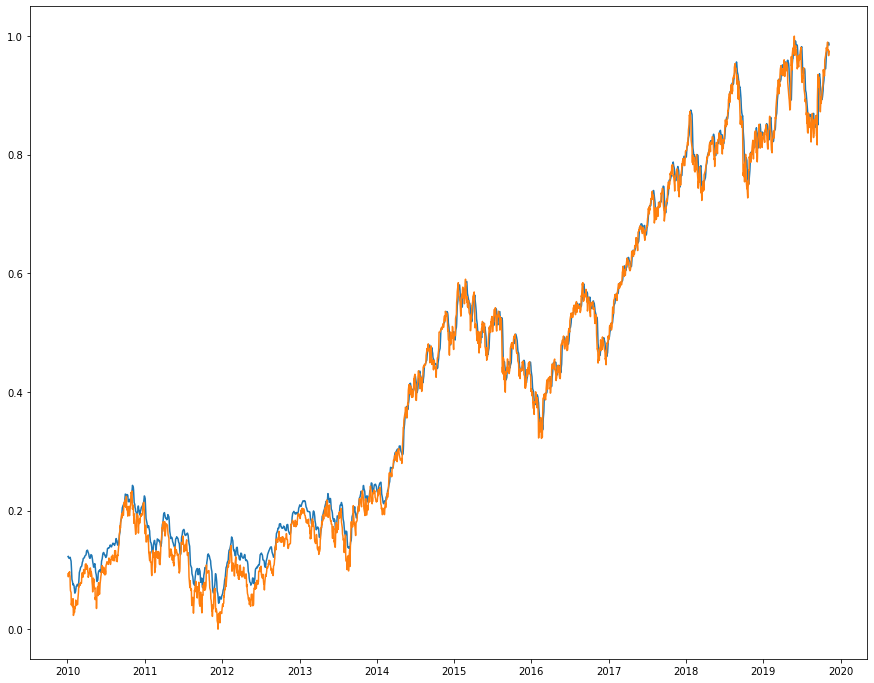

In [97]:
model_LSTM = load_model('model_lstm/')
train_predictions = model_LSTM.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1}, index=nifty50_train.index[:len(nifty50_train)-WINDOW_SIZE])

plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

Test RMSE: 0.02697363374193728


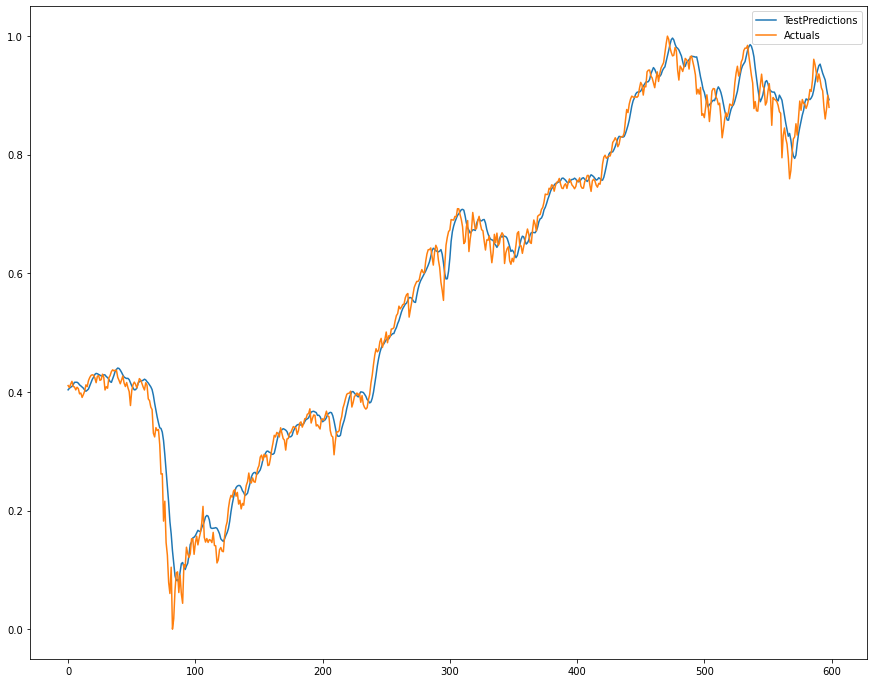

In [98]:
test_predictions = model_LSTM.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})

error = np.sqrt(mean_squared_error(test_results['Test Predictions'],test_results['Actuals']))
print("Test RMSE: {}".format(error))

plt.plot(test_results['Test Predictions'], label='TestPredictions')
plt.plot(test_results['Actuals'], label='Actuals')
plt.legend()

Convolution NN:

In [99]:
model_Conv = Sequential()
model_Conv.add(InputLayer((5, 1)))
model_Conv.add(Conv1D(64, kernel_size=2, activation='relu'))
model_Conv.add(Flatten())
model_Conv.add(Dense(8, 'relu'))
model_Conv.add(Dense(1, 'linear'))

model_Conv.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 4, 64)             192       
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 8)                 2056      
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [100]:
cp2 = ModelCheckpoint('model_Conv/', save_best_only=True)
model_Conv.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

model_Conv.fit(X_train1, y_train1, validation_split=0.25, epochs=10, callbacks=[cp2], shuffle=False)

Epoch 1/10
56/57 [============================>.] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0741INFO:tensorflow:Assets written to: model_Conv/assets


INFO:tensorflow:Assets written to: model_Conv/assets


57/57 [==============================] - 1s 17ms/step - loss: 0.0055 - root_mean_squared_error: 0.0739 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0808
Epoch 2/10
57/57 [==============================] - ETA: 0s - loss: 0.0062 - root_mean_squared_error: 0.0786INFO:tensorflow:Assets written to: model_Conv/assets


INFO:tensorflow:Assets written to: model_Conv/assets


57/57 [==============================] - 1s 15ms/step - loss: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0366
Epoch 3/10
30/57 [==============>...............] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0616INFO:tensorflow:Assets written to: model_Conv/assets


INFO:tensorflow:Assets written to: model_Conv/assets


57/57 [==============================] - 1s 15ms/step - loss: 0.0040 - root_mean_squared_error: 0.0631 - val_loss: 5.8809e-04 - val_root_mean_squared_error: 0.0243
Epoch 4/10
57/57 [==============================] - 0s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0393 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 5/10
57/57 [==============================] - 0s 3ms/step - loss: 7.0832e-04 - root_mean_squared_error: 0.0266 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0357
Epoch 6/10
57/57 [==============================] - 0s 3ms/step - loss: 3.9756e-04 - root_mean_squared_error: 0.0199 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 7/10
57/57 [==============================] - 0s 3ms/step - loss: 2.7533e-04 - root_mean_squared_error: 0.0166 - val_loss: 9.0575e-04 - val_root_mean_squared_error: 0.0301
Epoch 8/10
57/57 [==============================] - 0s 3ms/step - loss: 2.2785e-04 - root_mean_squared_error: 0.0151 - val_loss: 6.0439e-04 

INFO:tensorflow:Assets written to: model_Conv/assets


57/57 [==============================] - 1s 16ms/step - loss: 2.2195e-04 - root_mean_squared_error: 0.0149 - val_loss: 3.9785e-04 - val_root_mean_squared_error: 0.0199
Epoch 10/10
54/57 [===========================>..] - ETA: 0s - loss: 2.3912e-04 - root_mean_squared_error: 0.0155INFO:tensorflow:Assets written to: model_Conv/assets


INFO:tensorflow:Assets written to: model_Conv/assets


57/57 [==============================] - 1s 15ms/step - loss: 2.3277e-04 - root_mean_squared_error: 0.0153 - val_loss: 3.4153e-04 - val_root_mean_squared_error: 0.0185


Test RMSE: 0.024792337566151283


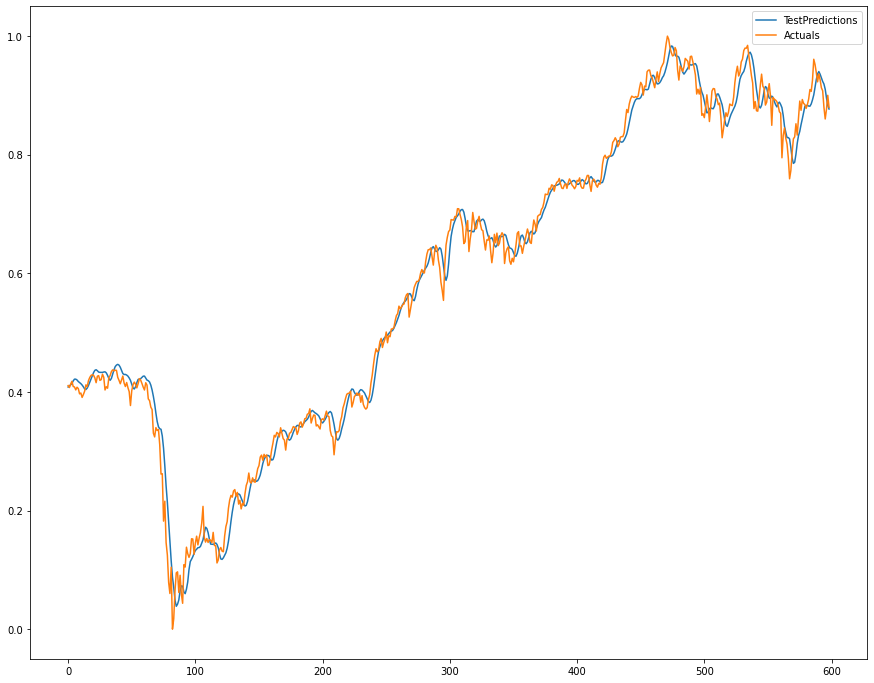

In [101]:
model_CONV = load_model('model_Conv/')
test_predictions = model_CONV.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})

error = np.sqrt(mean_squared_error(test_results['Test Predictions'],test_results['Actuals']))
print("Test RMSE: {}".format(error))

plt.plot(test_results['Test Predictions'], label='TestPredictions')
plt.plot(test_results['Actuals'], label='Actuals')
plt.legend()

GRU

In [102]:
model_gru = Sequential()
model_gru.add(InputLayer((5, 1)))
model_gru.add(GRU(64))
model_gru.add(Dense(8, 'relu'))
model_gru.add(Dense(1, 'linear'))
model_gru.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                12864     
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [103]:
cp3 = ModelCheckpoint('model_gru/', save_best_only=True)
model_gru.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

model_gru.fit(X_train1, y_train1, validation_split=0.25, epochs=10, callbacks=[cp3], shuffle=False)

Epoch 1/10
51/57 [=========================>....] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0405

INFO:tensorflow:Assets written to: model_gru/assets


INFO:tensorflow:Assets written to: model_gru/assets


57/57 [==============================] - 8s 93ms/step - loss: 0.0015 - root_mean_squared_error: 0.0393 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338
Epoch 2/10
49/57 [========================>.....] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0500

INFO:tensorflow:Assets written to: model_gru/assets


INFO:tensorflow:Assets written to: model_gru/assets


57/57 [==============================] - 5s 83ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 4.7706e-04 - val_root_mean_squared_error: 0.0218
Epoch 3/10
50/57 [=========================>....] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0475

INFO:tensorflow:Assets written to: model_gru/assets


INFO:tensorflow:Assets written to: model_gru/assets


57/57 [==============================] - 5s 93ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 4.2714e-04 - val_root_mean_squared_error: 0.0207
Epoch 4/10
49/57 [========================>.....] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0419

INFO:tensorflow:Assets written to: model_gru/assets


INFO:tensorflow:Assets written to: model_gru/assets


57/57 [==============================] - 5s 83ms/step - loss: 0.0016 - root_mean_squared_error: 0.0399 - val_loss: 2.5960e-04 - val_root_mean_squared_error: 0.0161
Epoch 5/10
56/57 [============================>.] - ETA: 0s - loss: 5.1464e-04 - root_mean_squared_error: 0.0227

INFO:tensorflow:Assets written to: model_gru/assets


INFO:tensorflow:Assets written to: model_gru/assets


57/57 [==============================] - 5s 82ms/step - loss: 5.1162e-04 - root_mean_squared_error: 0.0226 - val_loss: 2.1641e-04 - val_root_mean_squared_error: 0.0147
Epoch 6/10
57/57 [==============================] - 0s 6ms/step - loss: 2.2279e-04 - root_mean_squared_error: 0.0149 - val_loss: 2.1718e-04 - val_root_mean_squared_error: 0.0147
Epoch 7/10
49/57 [========================>.....] - ETA: 0s - loss: 1.6418e-04 - root_mean_squared_error: 0.0128

INFO:tensorflow:Assets written to: model_gru/assets


INFO:tensorflow:Assets written to: model_gru/assets


57/57 [==============================] - 5s 97ms/step - loss: 1.5878e-04 - root_mean_squared_error: 0.0126 - val_loss: 2.1116e-04 - val_root_mean_squared_error: 0.0145
Epoch 8/10
48/57 [========================>.....] - ETA: 0s - loss: 1.4883e-04 - root_mean_squared_error: 0.0122

INFO:tensorflow:Assets written to: model_gru/assets


INFO:tensorflow:Assets written to: model_gru/assets


57/57 [==============================] - 5s 83ms/step - loss: 1.4755e-04 - root_mean_squared_error: 0.0121 - val_loss: 2.0675e-04 - val_root_mean_squared_error: 0.0144
Epoch 9/10
57/57 [==============================] - 0s 6ms/step - loss: 1.4894e-04 - root_mean_squared_error: 0.0122 - val_loss: 2.0843e-04 - val_root_mean_squared_error: 0.0144
Epoch 10/10
57/57 [==============================] - 0s 7ms/step - loss: 1.5326e-04 - root_mean_squared_error: 0.0124 - val_loss: 2.1686e-04 - val_root_mean_squared_error: 0.0147


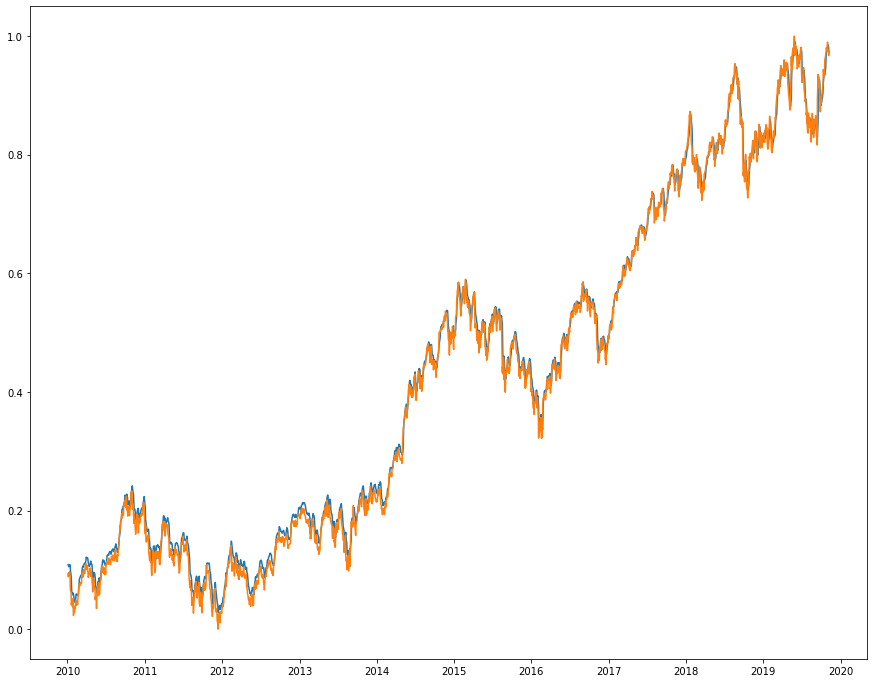

In [104]:
model_GRU = load_model('model_gru/')
train_predictions = model_GRU.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1}, index=nifty50_train.index[:len(nifty50_train)-WINDOW_SIZE])

plt.plot(train_results['Train Predictions'], label='Predictions')
plt.plot(train_results['Actuals'], label='Actuals')

Test RMSE: 0.02059461632908217


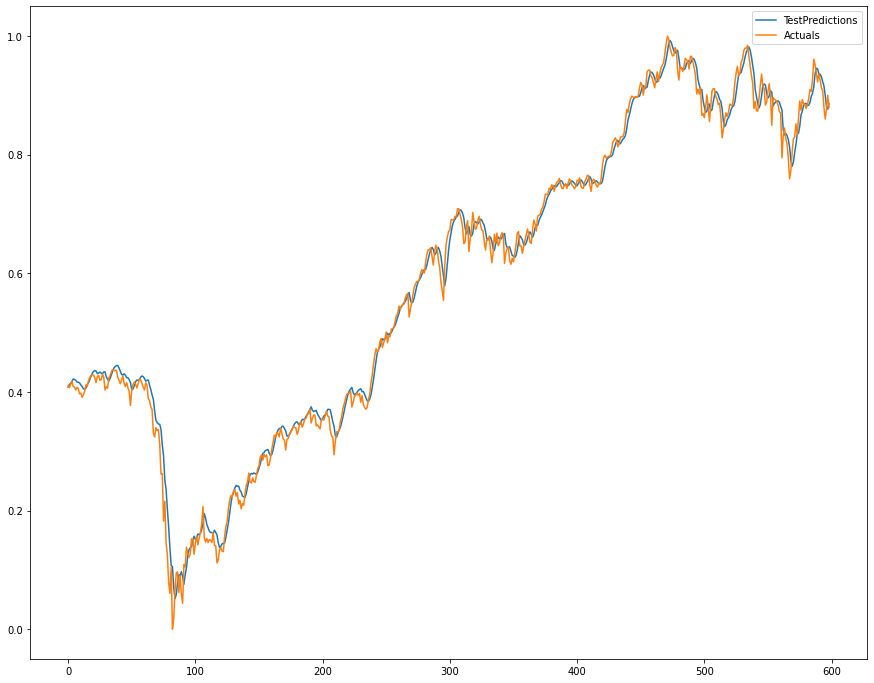

In [105]:
test_predictions = model_GRU.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})

error = np.sqrt(mean_squared_error(test_results['Test Predictions'],test_results['Actuals']))
print("Test RMSE: {}".format(error))

plt.plot(test_results['Test Predictions'], label='TestPredictions')
plt.plot(test_results['Actuals'], label='Actuals')
plt.legend()

Multi-variate Time Series Forecasting

In [106]:
df = nifty50[['Adj Close']].copy(deep=True)
df.rename(columns={'Adj Close':'Nifty50'}, inplace=True)

# Create 7 and 21 days Moving Average
df['ma7'] = df['Nifty50'].rolling(window=7).mean()
df['ma21'] = df['Nifty50'].rolling(window=21).mean()

# Create MACD
df['26ema'] = df['Nifty50'].ewm(span=26).mean()
df['12ema'] = df['Nifty50'].ewm(span=12).mean()
df['MACD'] = (df['12ema']-df['26ema'])

# Create Bollinger Bands
df['20sd'] = df['Nifty50'].rolling(window=20).std()
df['upper_band'] = df['ma21'] + (df['20sd']*2)
df['lower_band'] = df['ma21'] - (df['20sd']*2)

# Create Exponential moving average
df['ema'] = df['Nifty50'].ewm(com=0.5).mean()

# Create Momentum
df['momentum'] = df['Nifty50']-df['Nifty50'].shift(14)
#df['log_momentum'] = np.log(df['momentum'])



In [107]:
#Global peer indices - to be used as features
tickers = {'SP500':'^GSPC','SSE':'000001.SS','TWII':'^TWII','HSI':'^HSI','KOSPI':'^KS11'}

for index,ticker in tickers.items():
  df[index] = data.DataReader(ticker,data_source='yahoo', start='2010-01-01', end='2022-04-22')['Adj Close']
  
df.head()

,Nifty50,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,SP500,SSE,TWII,HSI,KOSPI
Date,,,,,,,,,,,,,,,,
2010-01-04,5232.200195,NaN,NaN,5232.200195,5232.200195,0.000000,NaN,NaN,NaN,5232.200195,NaN,1132.989990,3243.760010,8207.817383,21823.279297,1696.140015
2010-01-05,5277.899902,NaN,NaN,5255.928889,5256.954203,1.025314,NaN,NaN,NaN,5266.474976,NaN,1136.520020,3282.178955,8211.368164,22279.580078,1690.619995
2010-01-06,5281.799805,NaN,NaN,5265.224058,5266.651447,1.427389,NaN,NaN,NaN,5277.084473,NaN,1137.140015,3254.215088,8327.587891,22416.669922,1705.319946
2010-01-07,5263.100098,NaN,NaN,5264.630292,5265.530425,0.900133,NaN,NaN,NaN,5267.645020,NaN,1141.689941,3192.775879,8237.387695,22269.449219,1683.449951
2010-01-08,5244.750000,NaN,NaN,5260.019970,5259.884458,-0.135512,NaN,NaN,NaN,5252.318601,NaN,1144.979980,3195.997070,8280.868164,22296.750000,1695.260010


In [109]:
df.isnull().sum()

Nifty50         0
ma7             6
ma21           20
26ema           0
12ema           0
MACD            0
20sd           19
upper_band     20
lower_band     20
ema             0
momentum       14
SP500          77
SSE           194
TWII          177
HSI           137
KOSPI         142
dtype: int64

In [110]:
df.shape, df.dropna().shape

((3016, 16), (2545, 16))

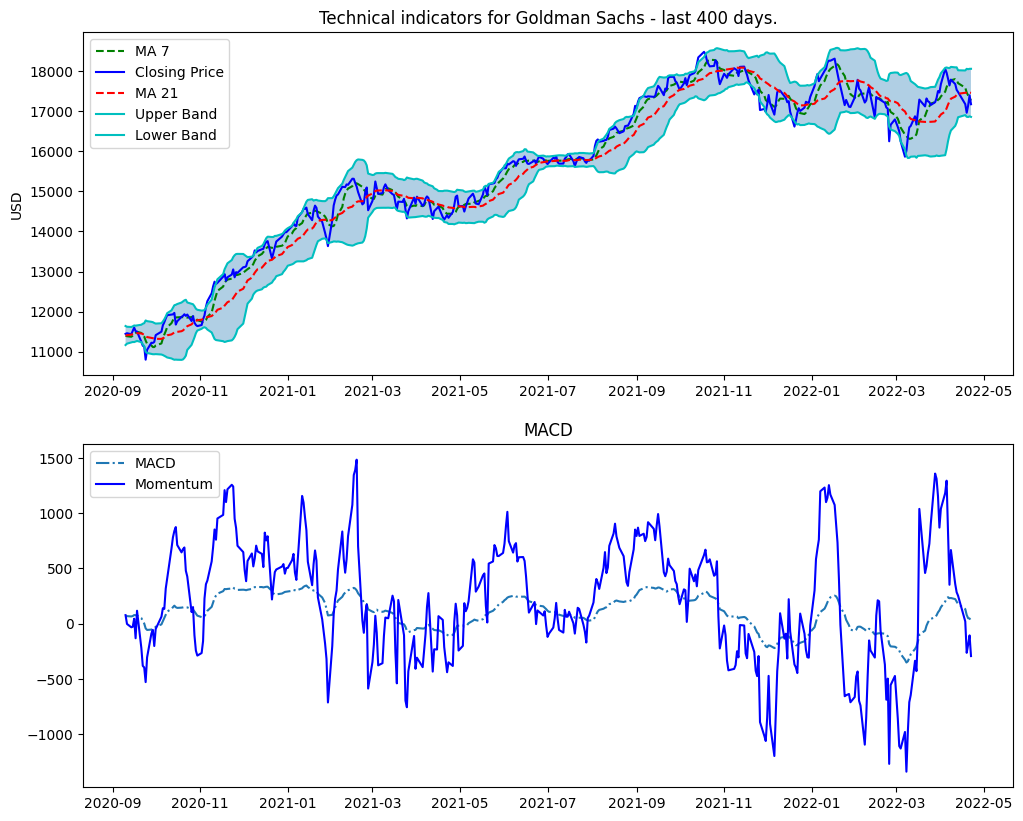

In [111]:
plot_TI_days = 400 #plotting Technical Indicators for the last 400 days

plt.figure(figsize=(12, 10), dpi=100)
shape_0 = df.shape[0]
xmacd_ = shape_0-plot_TI_days

dataset = df.iloc[-plot_TI_days:, :]
x_ = range(3, dataset.shape[0])
x_ =list(dataset.index)

# Plot first subplot
plt.subplot(2, 1, 1)
plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
plt.plot(dataset['Nifty50'],label='Closing Price', color='b')
plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
plt.plot(dataset['upper_band'],label='Upper Band', color='c')
plt.plot(dataset['lower_band'],label='Lower Band', color='c')
plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(plot_TI_days))
plt.ylabel('USD')
plt.legend()

# Plot second subplot
plt.subplot(2, 1, 2)
plt.title('MACD')
plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
#plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
#plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

plt.legend()
plt.show()

In [130]:
def df_to_X_y2(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [113]:
'''X2, y2 = df_to_X_y2(df, window_size=21)
X2.shape, y2.shape'''

((2995, 21, 16), (2995,))

In [131]:
df.isna().sum(), 

(Nifty50         0
 ma7             6
 ma21           20
 26ema           0
 12ema           0
 MACD            0
 20sd           19
 upper_band     20
 lower_band     20
 ema             0
 momentum       14
 SP500          77
 SSE           194
 TWII          177
 HSI           137
 KOSPI         142
 dtype: int64,)

In [132]:
df.shape, df.dropna().shape

((3016, 16), (2545, 16))

In [133]:
WINDOW_SIZE = 21

df_train = df.dropna()[:int(len(df.dropna())*0.8)]
df_test = df.dropna()[int(len(df.dropna())*0.8):]
df_train.shape, df_test.shape

((2036, 16), (509, 16))

In [134]:
train_scaler = MinMaxScaler()
df_train = pd.DataFrame(train_scaler.fit_transform(df_train), index=df_train.index, columns=df_train.columns)

test_scaler = MinMaxScaler()
df_test = pd.DataFrame(test_scaler.fit_transform(df_test), index=df_test.index, columns=df_test.columns)

In [135]:
X_train2, y_train2 = df_to_X_y2(df_train, WINDOW_SIZE)
X_test2, y_test2 = df_to_X_y2(df_test, WINDOW_SIZE)
X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

((2015, 21, 16), (2015,), (488, 21, 16), (488,))

In [118]:
'''X2_train, y2_train = X2[:60000], y2[:60000]
X2_val, y2_val = X2[60000:65000], y2[60000:65000]
X2_test, y2_test = X2[65000:], y2[65000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape'''

'X2_train, y2_train = X2[:60000], y2[:60000]\nX2_val, y2_val = X2[60000:65000], y2[60000:65000]\nX2_test, y2_test = X2[65000:], y2[65000:]\nX2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape'

In [119]:
'''temp_training_mean = np.mean(X2_train[:, :, 0])
temp_training_std = np.std(X2_train[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X'''

'temp_training_mean = np.mean(X2_train[:, :, 0])\ntemp_training_std = np.std(X2_train[:, :, 0])\n                           \ndef preprocess(X):\n  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std\n  return X'

In [120]:
'''preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)'''

'preprocess(X2_train)\npreprocess(X2_val)\npreprocess(X2_test)'

In [136]:
model_multivar_lstm = Sequential()
model_multivar_lstm.add(InputLayer((WINDOW_SIZE,16)))
model_multivar_lstm.add(LSTM(64))
model_multivar_lstm.add(Dense(8, 'relu'))
model_multivar_lstm.add(Dense(1, 'linear'))

model_multivar_lstm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                20736     
                                                                 
 dense_18 (Dense)            (None, 8)                 520       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 21,265
Trainable params: 21,265
Non-trainable params: 0
_________________________________________________________________


In [141]:
cp4 = ModelCheckpoint('model_multivar_lstm/', save_best_only=True)
model_multivar_lstm.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

model_multivar_lstm.fit(X_train2, y_train2, validation_split=0.25, epochs=50, callbacks=[cp4], shuffle=False)

Epoch 1/50
44/48 [==========================>...] - ETA: 0s - loss: 4.8965e-04 - root_mean_squared_error: 0.0221

INFO:tensorflow:Assets written to: model_multivar_lstm/assets


INFO:tensorflow:Assets written to: model_multivar_lstm/assets


48/48 [==============================] - 9s 141ms/step - loss: 4.9533e-04 - root_mean_squared_error: 0.0223 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0694
Epoch 2/50
44/48 [==========================>...] - ETA: 0s - loss: 4.1882e-04 - root_mean_squared_error: 0.0205

INFO:tensorflow:Assets written to: model_multivar_lstm/assets


INFO:tensorflow:Assets written to: model_multivar_lstm/assets


48/48 [==============================] - 5s 113ms/step - loss: 4.2226e-04 - root_mean_squared_error: 0.0205 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
Epoch 3/50
48/48 [==============================] - 1s 14ms/step - loss: 4.7949e-04 - root_mean_squared_error: 0.0219 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0473
Epoch 4/50
44/48 [==========================>...] - ETA: 0s - loss: 5.4041e-04 - root_mean_squared_error: 0.0232

INFO:tensorflow:Assets written to: model_multivar_lstm/assets


INFO:tensorflow:Assets written to: model_multivar_lstm/assets


48/48 [==============================] - 5s 112ms/step - loss: 5.4431e-04 - root_mean_squared_error: 0.0233 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 5/50
48/48 [==============================] - ETA: 0s - loss: 4.6548e-04 - root_mean_squared_error: 0.0216

INFO:tensorflow:Assets written to: model_multivar_lstm/assets


INFO:tensorflow:Assets written to: model_multivar_lstm/assets


48/48 [==============================] - 6s 131ms/step - loss: 4.6548e-04 - root_mean_squared_error: 0.0216 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389
Epoch 6/50
47/48 [============================>.] - ETA: 0s - loss: 5.6332e-04 - root_mean_squared_error: 0.0237

INFO:tensorflow:Assets written to: model_multivar_lstm/assets


INFO:tensorflow:Assets written to: model_multivar_lstm/assets


48/48 [==============================] - 5s 115ms/step - loss: 5.6078e-04 - root_mean_squared_error: 0.0237 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 7/50
45/48 [===========================>..] - ETA: 0s - loss: 5.6382e-04 - root_mean_squared_error: 0.0237

INFO:tensorflow:Assets written to: model_multivar_lstm/assets


INFO:tensorflow:Assets written to: model_multivar_lstm/assets


48/48 [==============================] - 5s 114ms/step - loss: 5.4673e-04 - root_mean_squared_error: 0.0234 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348
Epoch 8/50
48/48 [==============================] - 1s 14ms/step - loss: 6.4151e-04 - root_mean_squared_error: 0.0253 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 9/50
48/48 [==============================] - 1s 16ms/step - loss: 6.8991e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 10/50
48/48 [==============================] - 1s 14ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0490
Epoch 11/50
48/48 [==============================] - 1s 14ms/step - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0665
Epoch 12/50
48/48 [==============================] - 1s 14ms/step - loss: 0.0037 - root_mean_squared_error: 0.0608 - val_loss: 0.0136 - val_r

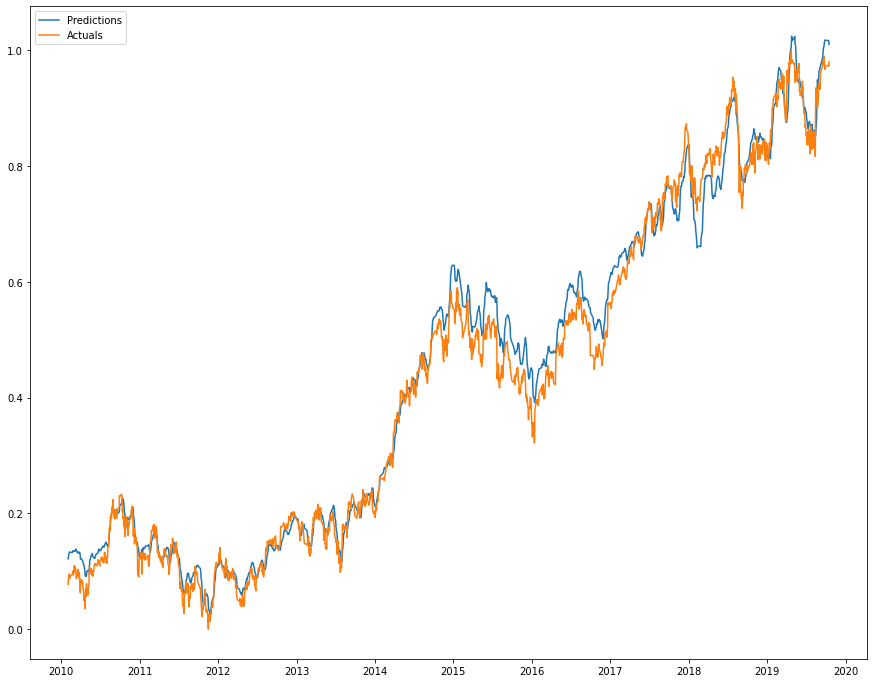

In [144]:
model_multivar_LSTM = load_model('model_multivar_lstm/')
train_predictions = model_multivar_LSTM.predict(X_train2).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train2}, index=df_train.index[:len(df_train)-WINDOW_SIZE])

plt.plot(train_results['Train Predictions'], label='Predictions')
plt.plot(train_results['Actuals'], label='Actuals')
plt.legend()

Test RMSE: 0.03728603452639509


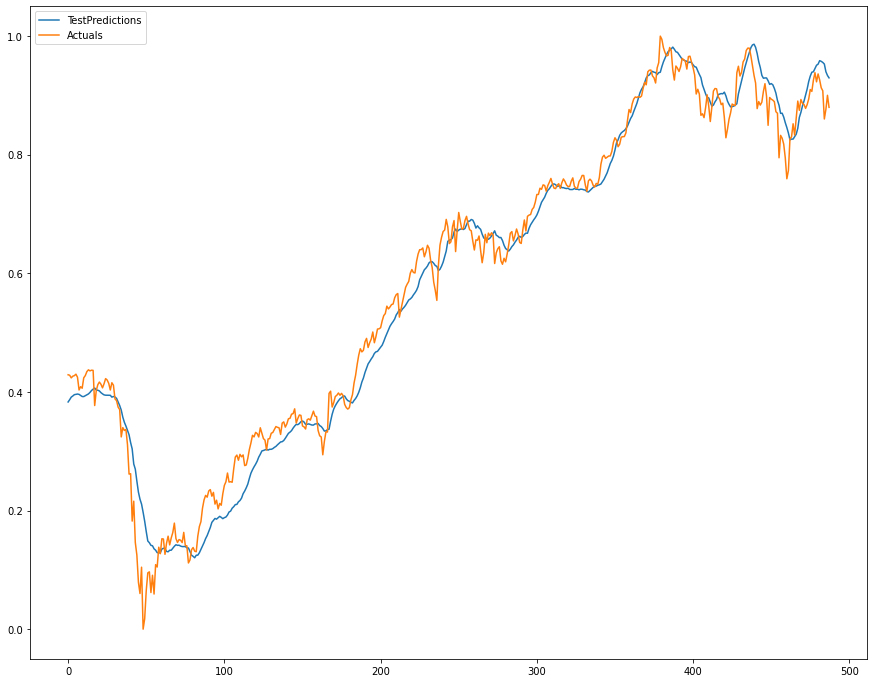

In [143]:
test_predictions = model_multivar_LSTM.predict(X_test2).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test2})

error = np.sqrt(mean_squared_error(test_results['Test Predictions'],test_results['Actuals']))
print("Test RMSE: {}".format(error))

plt.plot(test_results['Test Predictions'], label='TestPredictions')
plt.plot(test_results['Actuals'], label='Actuals')
plt.legend()